In [1]:
import pandas as pd
import nltk

# Read the CSV file (fixed the quotes)
df = pd.read_csv("C:\\Users\\abcjv\\Downloads\\spotify_reviews.csv", usecols=['content', 'score'])

# Display the DataFrame
df

,content,score
0,It's good,4
1,"I love this app so much, I've been using Spoti...",5
2,Perfect,5
3,Best all around music streaming app I have use...,5
4,Are y'all fr gatekeeping the play button on so...,1
...,...,...
84160,The most decent music streaming app around rig...,3
84161,"As a premium user for a few years, Spotify is ...",4
84162,"There is lot of ads all of a sudden, and it's ...",3
84163,The UI could be better. I think there should b...,4


In [2]:
# Function to convert rating stars to sentiment
def stars_to_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

# Ensure 'score' column exists before applying
if 'score' in df.columns:
    df['sentiment'] = df['score'].apply(stars_to_sentiment)
else:
    print("Error: Column 'score' not found in DataFrame.")

# Correct way to select multiple columns
df


,content,score,sentiment
0,It's good,4,positive
1,"I love this app so much, I've been using Spoti...",5,positive
2,Perfect,5,positive
3,Best all around music streaming app I have use...,5,positive
4,Are y'all fr gatekeeping the play button on so...,1,negative
...,...,...,...
84160,The most decent music streaming app around rig...,3,neutral
84161,"As a premium user for a few years, Spotify is ...",4,positive
84162,"There is lot of ads all of a sudden, and it's ...",3,neutral
84163,The UI could be better. I think there should b...,4,positive


In [3]:
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Ensure necessary NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Expand contractions
    contractions = {
        "isn't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
        "hasn't": "has not", "haven't": "have not", "hadn't": "had not", "isn't": "is not",
        "it's": "it is", "let's": "let us", "ma'am": "madam", "mightn't": "might not",
        "mustn't": "must not", "needn't": "need not", "needn't": "need not", "shan't": "shall not",
        "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
        "they're": "they are", "they've": "they have", "wasn't": "was not", "weren't": "were not",
        "what's": "what is", "what'll": "what will", "what're": "what are", "what've": "what have",
        "where's": "where is", "where've": "where have", "who's": "who is", "who'll": "who will",
        "who're": "who are", "who've": "who have", "why's": "why is", "why're": "why are",
        "why've": "why have", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
        "you'll": "you will", "you're": "you are", "you've": "you have"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Define English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Customize the stopwords list for sentiment analysis (add negations or important words)
    sentiment_important_words = {"not", "no", "very", "good", "bad", "excellent", "love", "hate", "great", "feel", "wish", "would", "should"}
    stop_words = stop_words - sentiment_important_words  # Remove sentiment important words from stopwords

    # Function to map POS tag to wordnet format
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to NOUN if unknown

    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Apply lemmatization based on POS tags and filter out stopwords
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
        if word.isalnum() and word not in stop_words
    ]
    
    # Join the lemmatized tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Test the function
df['processed_content'] = df['content'].apply(preprocess_text)
df


,content,score,sentiment,processed_content
0,It's good,4,positive,good
1,"I love this app so much, I've been using Spoti...",5,positive,love app much ive use spotify 2 year different...
2,Perfect,5,positive,perfect
3,Best all around music streaming app I have use...,5,positive,best around music stream app use family plan g...
4,Are y'all fr gatekeeping the play button on so...,1,negative,yall fr gatekeeping play button song
...,...,...,...,...
84160,The most decent music streaming app around rig...,3,neutral,decent music stream app around right kink ridi...
84161,"As a premium user for a few years, Spotify is ...",4,positive,premium user year spotify fantastic service us...
84162,"There is lot of ads all of a sudden, and it's ...",3,neutral,lot ad sudden even watch video want uninterrup...
84163,The UI could be better. I think there should b...,4,positive,ui could good think should search bar time lik...


In [ ]:
import random
import time
from sklearn.utils import resample
from deep_translator import GoogleTranslator
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm for progress bar
import pandas as pd

# Global variable to track the number of requests made today
requests_today = 0
MAX_REQUESTS_PER_DAY = 200000
REQUESTS_PER_SECOND = 5
SECONDS_PER_REQUEST = 1 / REQUESTS_PER_SECOND

# Function to perform back-translation and preprocessing with error handling
def back_translate(text, src_lang, intermediate_lang1, intermediate_lang2):
    global requests_today
    
    if requests_today >= MAX_REQUESTS_PER_DAY:
        print("Daily request limit reached!")
        return preprocess_text(text)  # Return original text if request limit is reached

    try:
        # Translate to the first intermediate language
        translated1 = GoogleTranslator(source=src_lang, target=intermediate_lang1).translate(text)
        
        # Translate to the second intermediate language
        translated2 = GoogleTranslator(source=intermediate_lang1, target=intermediate_lang2).translate(translated1)
        
        # Translate back to the source language
        back_translated = GoogleTranslator(source=intermediate_lang2, target=src_lang).translate(translated2)
        
        # Increment request counter
        requests_today += 3  # One request for each translation stage (3 translations)
        
        time.sleep(SECONDS_PER_REQUEST)  # Ensure we don't exceed the requests per second limit
        
        return preprocess_text(back_translated)
    
    except Exception as e:
        # If any translation fails, log the error and return the original text
        print(f"Error during translation: {e}")
        return preprocess_text(text)  # Return the original text if translation fails

# Parallelized function to oversample with back-translation and show progress bar
def oversample_with_back_translation(samples, oversample_count, sentiment_label, src_lang='en', intermediate_lang1='es', intermediate_lang2='fr'):
    # Create new samples using back-translation
    new_samples = []
    
    # Wrap the loop with ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=64) as executor:
        futures = []
        
        # Wrap the range of oversampling count with tqdm to show progress
        with tqdm(total=oversample_count, desc=f'Oversampling {sentiment_label}', unit='sample') as pbar:
            # Submit tasks to executor
            for _ in range(oversample_count):
                random_sample = random.choice(samples['content'].tolist())  # Choose a random sample
                futures.append(executor.submit(back_translate, random_sample, src_lang, intermediate_lang1, intermediate_lang2))
            
            # Collect the results as they finish and update the progress bar
            for future in futures:
                future.result()  # This will block until the task is finished
                new_samples.append({
                    'content': future.result(),
                    'sentiment': sentiment_label
                })
                pbar.update(1)  # Update progress bar after each completed sample
    
    # Convert new samples to a DataFrame
    new_samples_df = pd.DataFrame(new_samples)
    
    return new_samples_df

# Assuming df is your original DataFrame
# Separate the data by sentiment
negative_samples = df[df['sentiment'] == 'negative']
neutral_samples = df[df['sentiment'] == 'neutral']
positive_samples = df[df['sentiment'] == 'positive']

# Define the target size for oversampling (matching the negative class size)
target_size = len(negative_samples)  # 48,906 in this case

# Calculate the oversample count for each class
neutral_oversample_count = target_size - len(neutral_samples)
positive_oversample_count = target_size - len(positive_samples)

# Ensure oversampling counts are non-negative (if a class is already larger than the target size, don't oversample)
neutral_oversample_count = max(neutral_oversample_count, 0)
positive_oversample_count = max(positive_oversample_count, 0)

# Oversample each class with back-translation
neutral_oversampled = oversample_with_back_translation(neutral_samples, neutral_oversample_count, 'neutral')
positive_oversampled = oversample_with_back_translation(positive_samples, positive_oversample_count, 'positive')

# Combine the oversampled classes to create a more balanced dataset
balanced_df = pd.concat([negative_samples, neutral_oversampled, positive_oversampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the class balance
print(balanced_df['sentiment'].value_counts())  # Check class balance


Oversampling neutral:   3%|▎         | 1112/36887 [01:07<16:11, 36.82sample/s] 

Error during translation: Calificaría la aplicación más alto, pero mi Volkswagen Jetta 2019 y OnePlus 12 no siempre trabajan juntos. --> No translation was found using the current translator. Try another translator?
Error during translation: ¡Qué está pasando aquí, la música se detiene solo por nada! ¡Tengo una buena red y mi modo de ahorro de energía está apagado! Me molesta en grrr. Tengo una cuenta premium y creo que no es normal que pague una música que ni siquiera puedo escuchar desde el principio hasta el final. La última actualización hizo que la experiencia de su aplicación se degradara terriblemente. Además, eliminó el control de widget.omg Whyyy --> No translation was found using the current translator. Try another translator?


Oversampling neutral:   3%|▎         | 1262/36887 [01:16<27:20, 21.72sample/s]

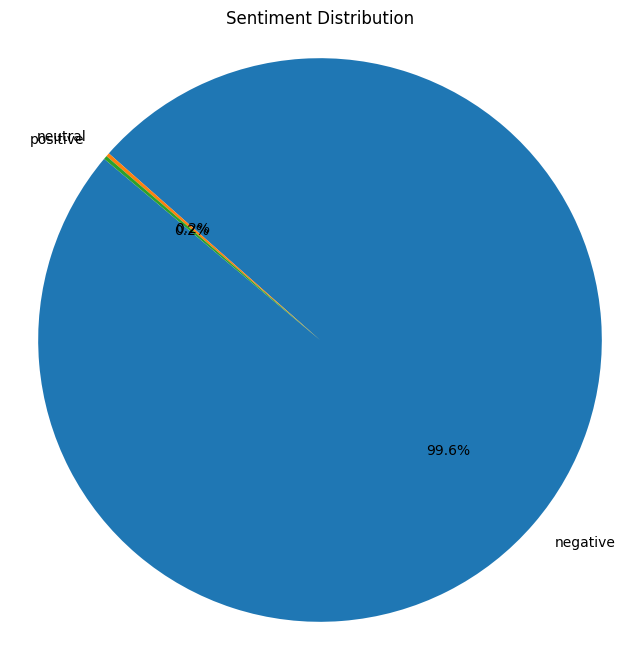

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Count the number of occurrences for each sentiment category
sentiment_count = balanced_df['sentiment'].value_counts()

plt.figure(figsize=(8, 8))  # Set the figure size

# Create a pie chart to visualize sentiment distribution
plt.pie(sentiment_count, labels=sentiment_count.index, autopct="%1.1f%%", startangle=140)

plt.title('Sentiment Distribution')  # Add a title to the chart
plt.axis('equal')  # Ensure the pie chart is displayed as a circle
plt.show()  # Display the plot

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(balanced_df['processed_content'], balanced_df['sentiment'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer with bigrams, minimum document frequency of 3, and max document frequency of 90%
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, sublinear_tf=True)

# Fit the vectorizer on training data and transform it into numerical feature vectors
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_vectorized = vectorizer.transform(X_test)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vectorized, y_train)
preds = rf.predict(X_test_vectorized)
print(classification_report(y_test, preds))